In [1]:
%pylab inline
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

day = "20170205"

df = pd.read_csv("bus_time_%s.csv"%day)

## Choosing a specific stop
NEXT_STOP = '552993'
vehicles = df[df['next_stop_id'] == NEXT_STOP]['vehicle_id'].unique().tolist()
dd = df[df['vehicle_id'].apply(lambda x: x in vehicles)].sort('timestamp').set_index('timestamp')
dd = dd[dd['next_stop_id'].apply(str.isdigit)]


## Bus arrival times
bus_times = pd.DataFrame()
for bus, group in dd.groupby('vehicle_id'):
    group['next_stop_id_diff'] = group['next_stop_id'].astype(int).diff().shift(-1)
    bus_times = pd.concat([bus_times, group[(group['next_stop_id']== NEXT_STOP) & group['next_stop_id_diff'] != 0].copy()])

bus_times = bus_times[['vehicle_id','next_stop_id','dist_from_stop']].sort().reset_index()
bus_times['timestamp'] = pd.to_datetime(bus_times['timestamp'])
bus_times['timestamp_seconds'] = bus_times['timestamp'].apply(lambda x: int(x.strftime('%s'))) 
bus_times['diff'] = bus_times['timestamp'].diff().apply(lambda x: x.total_seconds())

/Users/stephenma/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/stephenma/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Populating the interactive namespace from numpy and matplotlib


/Users/stephenma/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: FutureWarning: sort(....) is deprecated, use sort_index(.....)


count     333.000000
mean      257.648649
std       357.300791
min         0.000000
25%        73.000000
50%       156.500000
75%       297.500000
max      3454.000000
Name: diff, dtype: float64


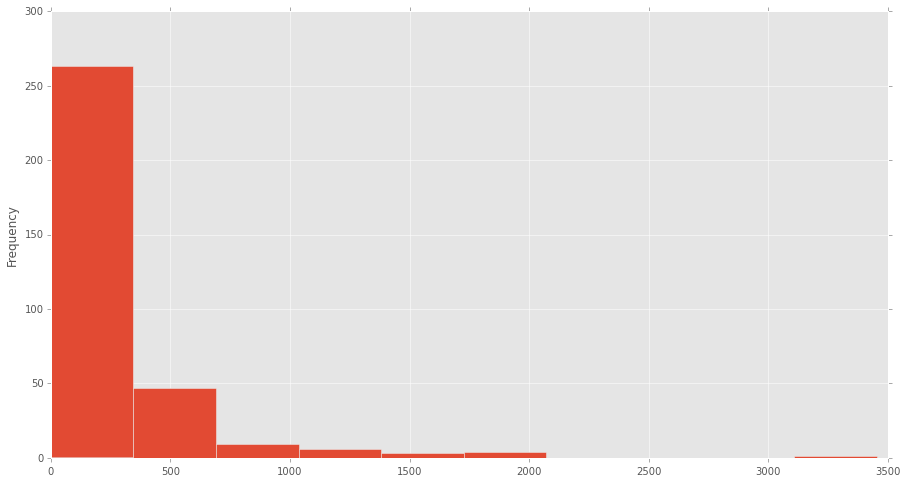

In [2]:
bus_times['diff'].plot(kind = 'hist', figsize = [15,8])
print bus_times['diff'].describe()

### Simulating waiting times

In [17]:
start = int(datetime.strptime(day, "%Y%m%d").strftime('%s'))
end = int(bus_times['timestamp'].iloc[-1].strftime('%s'))

# Passenger Arrival times
rands = pd.DataFrame({'pass_times': np.random.random_integers(start, end, 50000)})

# Bus Arrival times
rands['bus_times'] = rands['pass_times'].apply(lambda x: bus_times[bus_times['timestamp_seconds']>= x]['timestamp_seconds'].iloc[0])
rands['wait_time'] = (rands['bus_times'] - rands['pass_times'])/60.

count    50000.000000
mean         6.214770
std          8.271503
min          0.000000
25%          1.250000
50%          3.116667
75%          7.433333
max         57.550000
Name: wait_time, dtype: float64


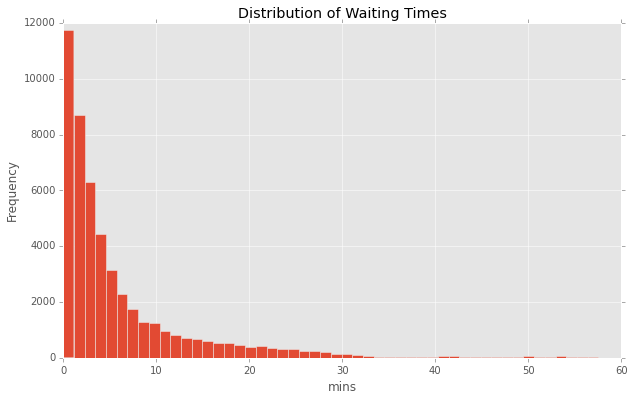

In [18]:
ax = rands['wait_time'].plot(kind = 'hist', figsize = [10,6], bins = 50, title = "Distribution of Waiting Times")
ax.set_xlabel("mins")
print rands['wait_time'].describe()

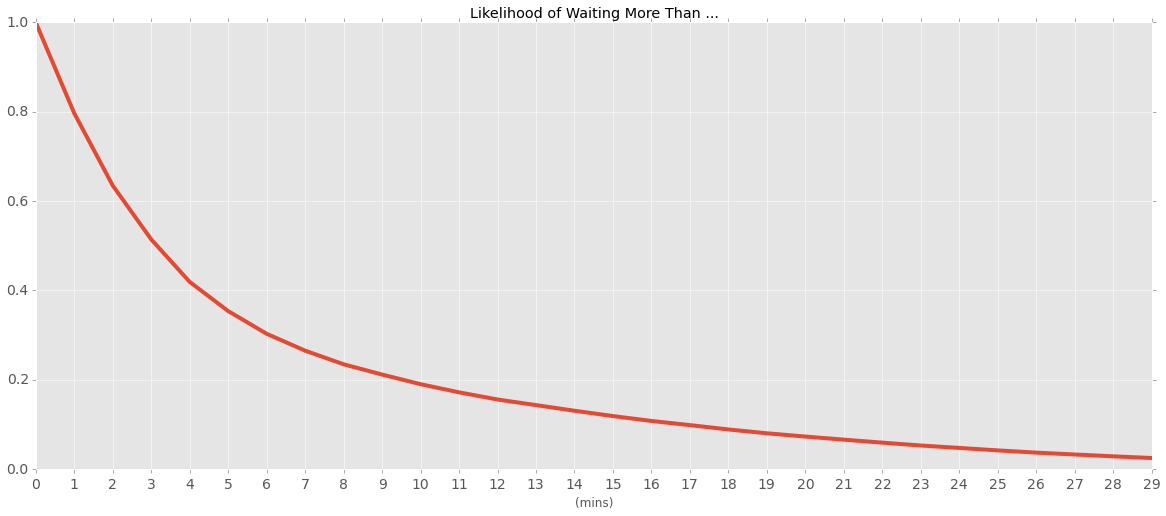

In [40]:
rhs = pd.DataFrame({'S':np.arange(0, 30, 1)})
rhs['waiting'] = rhs['S'].apply(lambda x: len(rands[rands['wait_time'] >= x]))
rhs['waiting'] = rhs['waiting'] / float(len(rands))
ax = rhs.set_index('S')['waiting'].plot(figsize = [20,8], lw = 4, fontsize = 14, 
                                        title = "Likelihood of Waiting More Than ... ")
ax.set_xlabel("(mins)")
_ = ax.set_xticks(np.arange(0, 30, 1))
_  = ax.set_xticklabels( np.arange(0, 30, 1) )

In [41]:
TT = [.25, .5, 1, 2, 5, 10]

for T in TT:
    print T
    rhs['waiting after '+str(T)+" mins"] = rhs['S'].apply(lambda x: len(rands[rands['wait_time'] >= x + T]) / float(len(rands[rands['wait_time'] >= T]) ))

0.25
0.5
1
2
5
10


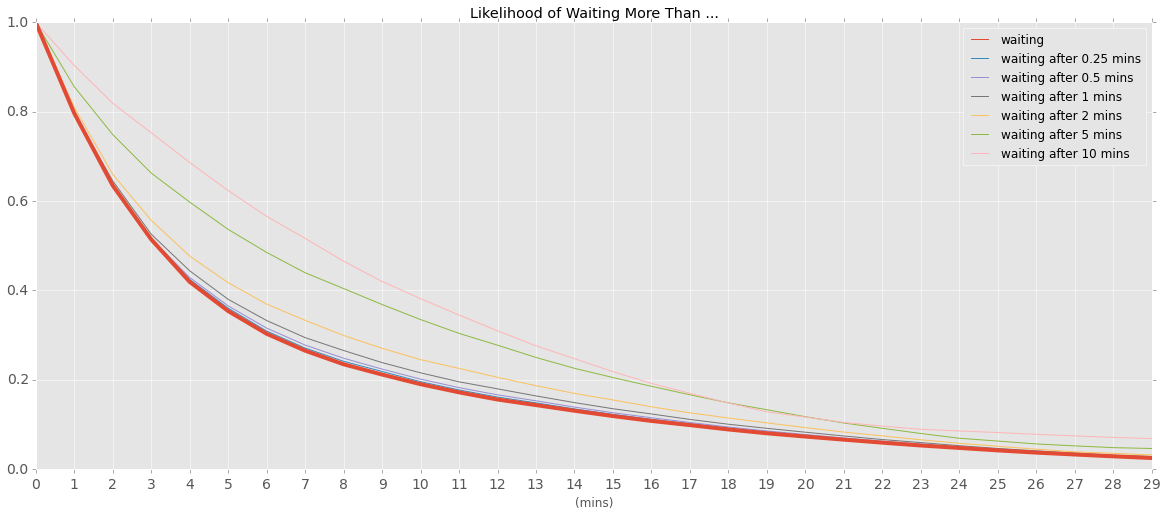

In [42]:
ax = rhs.set_index('S').plot(figsize = [20,8], fontsize = 14)

rhs.set_index('S')['waiting'].plot(ax = ax, lw = 4,title = "Likelihood of Waiting More Than ... ")

ax.set_xlabel("(mins)")
_ = ax.set_xticks(np.arange(0, 30, 1))
_  = ax.set_xticklabels( np.arange(0, 30, 1) )